In [1]:
%matplotlib inline
import skimage.transform
import math
import matplotlib.pyplot as plt
import skimage.data

In [2]:
from mxnet import nd

C:\Users\v-dinliu\AppData\Local\Continuum\anaconda3\envs\mxnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%%time
import sys
sys.path.append('//msralab/projectdata/ehealth02/v-dinliu/Flow2D')
from reader.chairs import binary_reader, trainval
trainSet, validationSet = trainval.read('//msralab/ProjectData/ehealth02/v-dinliu/Flow2D/Data/FlyingChairs_release/FlyingChairs_train_val.txt')
validationSize = len(validationSet)
validationImg1, validationImg2, validationFlow = binary_reader.load(r"\\msralab\ProjectData\ScratchSSD\Users\v-dinliu\data\FlyingChairsBlock", "val")

Wall time: 18.5 s


In [4]:
cd ..

Z:\v-dinliu\Flow2D


In [5]:
import network

In [12]:
from visualization import flow2rgb
import numpy as np

In [19]:
def call_mx_func(func, *args, **kwargs):
    prep_func = kwargs.get('prep', lambda x : x)
    nd_args = []
    for arg in args:
        if arg.ndim == 3:
            arg = np.expand_dims(arg, 0)
        nd_args.append(prep_func(nd.transpose(nd.array(arg), (0, 3, 1, 2))))
    nd_rets = func(*nd_args)
    if isinstance(nd_rets, nd.NDArray):
        ret = nd.transpose(ret, (0, 2, 3, 1)).asnumpy()
        if ret.shape[0] == 1:
            ret = ret[0]
        return ret
    else:
        rets = []
        for ret in nd_rets: 
            ret = nd.transpose(ret, (0, 2, 3, 1)).asnumpy()
            if ret.shape[0] == 1:
                ret = ret[0]
            rets.append(ret)
        return rets

In [8]:
import mxnet as mx
import yaml

In [9]:
with open('network/config/spynet.yaml') as fi:
    cfg = yaml.load(fi)

In [10]:
pipe = network.get_pipeline('hybridnet-coarse', config=cfg, ctx=[mx.cpu()])

In [11]:
pipe.network.collect_params().load('weights/94fApr10-1831_400000.params', ctx=pipe.ctx)

In [29]:
pipe.network.collect_params().initialize(force_reinit=True, ctx=pipe.ctx)

In [45]:
for k, v in pipe.network.collect_params().items():
    if k.endswith('weight'):
        v.initialize(mx.initializer.Normal(sigma=0.01), force_reinit=True, ctx=mx.cpu())
    else:
        v.initialize(force_reinit=True, ctx=mx.cpu())

In [55]:
v.grad()


[0. 0.]
<NDArray 2 @cpu(0)>

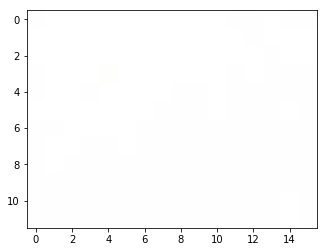

In [51]:
i = 3
flow, = call_mx_func(pipe.network, validationImg1[i] / 255.0, validationImg2[i] / 255.0, prep=pipe.preprocess)
flow = flow * 32
plt.imshow(flow2rgb(flow))

In [ ]:
factor = 32

In [ ]:
img = validationFlow[14]
plt.figure()
plt.imshow(flow2rgb(img))
plt.figure()
ds_img = call_mx_func(network.flownet.Downsample(factor), img)
upsamp = network.flownet.Upsample(2, factor)
upsamp.collect_params().initialize()
plt.imshow(flow2rgb(ds_img))
plt.figure()
rs_img = call_mx_func(upsamp, ds_img)
plt.imshow(flow2rgb(rs_img))
epe = np.mean(np.linalg.norm(img - rs_img, axis=-1))
print(epe)

In [ ]:
import numpy as np

In [ ]:
epes = []
orig_epes = []
for i in np.random.choice(range(len(validationFlow)), size=100, replace=False):
    dsflow = call_mx_func(network.flownet.Downsample(factor), validationFlow[i])
    epes.append(np.mean(np.linalg.norm(dsflow, axis=-1)))
    orig_epes.append(np.mean(np.linalg.norm(validationFlow[i], axis=-1)))

In [ ]:
print(np.mean(epes))
print(np.mean(orig_epes))